In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.externals import joblib
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
from scipy.optimize import minimize

%matplotlib inline

Using CNTK backend
c:\python27\lib\site-packages\keras\backend\cntk_backend.py:18: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [87]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    print len(new_row), new_row
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    print array.shape
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def scale(test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.fit_transform(test)
    return scaler, test_scaled

In [71]:
weather_b = pd.read_csv('data/weather_UTC_2012-2016_Berlin.csv', sep=';', decimal=',')
weather_b.VALUE_TIME = pd.to_datetime(weather_b.VALUE_TIME)
weather_b.set_index('VALUE_TIME', inplace=True)

weather_m = pd.read_csv('data/weather_UTC_2012-2016_Munich.csv', sep=';', decimal=',')
weather_m.VALUE_TIME = pd.to_datetime(weather_m.VALUE_TIME)
weather_m.set_index('VALUE_TIME', inplace=True)

weather_d = pd.read_csv('data/weather_UTC_2012-2016_Dusseldorf.csv', sep=';', decimal=',')
weather_d.VALUE_TIME = pd.to_datetime(weather_d.VALUE_TIME)
weather_d.set_index('VALUE_TIME', inplace=True)

In [72]:
energy = pd.read_csv('data/production_consumption_2012_2016_scaled.csv', sep=';', decimal=',')
energy['timestamp'] = pd.to_datetime(energy['cet_cest_timestamp'])
energy.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)
energy.set_index('timestamp', inplace=True)

In [73]:
pred_wind = joblib.load('models/wind_prediction_model.sav')
pred_sun = joblib.load('models/solar_prediction_model.sav')

# load RNN model
json_file = open('models/consumption_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
pred_consumption = model_from_json(loaded_model_json)
pred_consumption.load_weights("models/consumption_model_weights.h5")
pred_consumption.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

c:\python27\lib\site-packages\keras\backend\cntk_backend.py:2337: UserWarning: CNTK backend warning: CNTK version not detected. Will using CNTK 2.0 GA as default.
  'CNTK backend warning: CNTK version not detected. '
c:\python27\lib\site-packages\keras\backend\cntk_backend.py:2337: UserWarning: CNTK backend warning: CNTK version not detected. Will using CNTK 2.0 GA as default.
  'CNTK backend warning: CNTK version not detected. '
c:\python27\lib\site-packages\keras\backend\cntk_backend.py:2337: UserWarning: CNTK backend warning: CNTK version not detected. Will using CNTK 2.0 GA as default.
  'CNTK backend warning: CNTK version not detected. '


In [74]:
weather_m.head()

,t_2m,precip_1h,global_rad,wind_speed_10m
VALUE_TIME,,,,
2011-12-31 00:00:00,-1.6,0.16,0.0,17.1
2011-12-31 01:00:00,-1.9,0.08,0.0,14.7
2011-12-31 02:00:00,-2.1,0.08,0.0,12.3
2011-12-31 03:00:00,-2.4,0.08,0.0,10.0
2011-12-31 04:00:00,-2.4,0.03,0.0,9.7


In [75]:
def cost_function(params):
    p_hat = params[0]
    c_hat = params[1]
    b_hat = params[2]
    
    b = []
    for i in range(24):
        b[i] = c_hat[i] - p_hat[i] - b_hat[i]
    return b

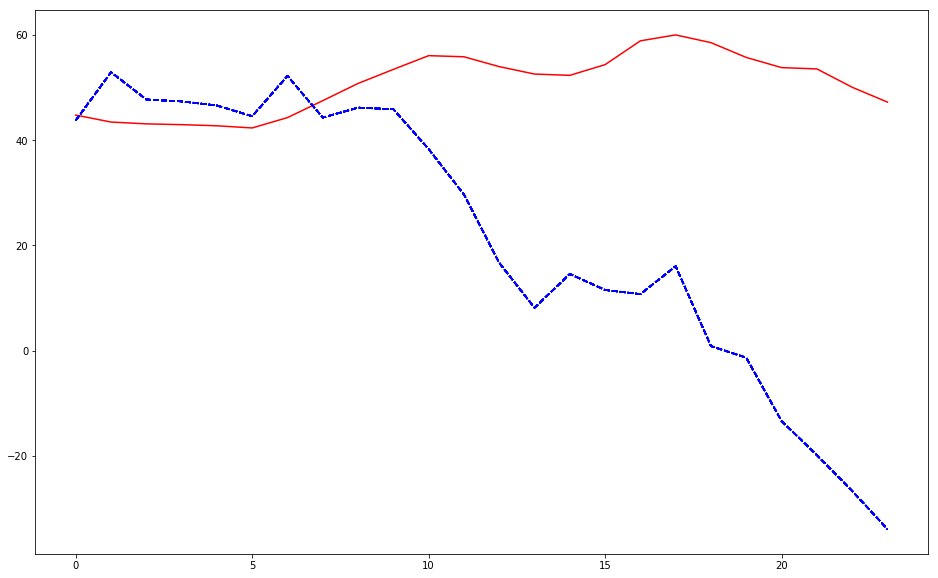

In [89]:
base = datetime.datetime(2016, 1, 1)
battery_pred = np.zeros(24)
lag = 24
for day in [base + datetime.timedelta(days=x) for x in range(0, 10)]:
    next_day =  day+datetime.timedelta(days=1)
    
    X_solar = np.array(pd.concat([weather_m[(weather_m.index >= day) & (weather_m.index < next_day)][['global_rad']],
                            weather_b[(weather_b.index >= day) & (weather_b.index < next_day)][['global_rad']],
                            weather_d[(weather_d.index >= day) & (weather_d.index < next_day)][['global_rad']]
                           ], axis=1)
                )
    
    X_wind = np.array(pd.concat([weather_m[(weather_m.index >= day) & (weather_m.index < next_day)][['wind_speed_10m']],
                            weather_b[(weather_b.index >= day) & (weather_b.index < next_day)][['wind_speed_10m']],
                            weather_d[(weather_d.index >= day) & (weather_d.index < next_day)][['wind_speed_10m']]
                           ], axis=1)
                )
    '''
    X = weather_b[(weather_b.index >= day) & (weather_b.index < next_day)].merge(
        weather_d[(weather_d.index >= day) & (weather_d.index < next_day)], left_index=True, right_index=True).merge(
        weather_m[(weather_m.index >= day) & (weather_m.index < next_day)], left_index=True, right_index=True)
    
    X_cons = series_to_supervised(X.values, 1, 1, True)
    X_cons['y'] = 0
    
    scaler, X_scaled = scale(np.array(X_cons))
    consumption_pred = []
    for i in range(len(X_scaled)):
        # make one-step forecast
        X_i = X_scaled[i]
        yhat = forecast_lstm(pred_consumption, 1, X_i)
        # invert scaling
        yhat = invert_scale(scaler, X_i, yhat)
        # store forecast
        consumption_pred.append(yhat)
      
    '''
    consumption =  np.array(energy[(energy.index >= day) & (energy.index < next_day)]['consumption'])
    solar = np.array(energy[(energy.index >= day) & (energy.index < next_day)]['solarprod'])
    wind =  np.array(energy[(energy.index >= day) & (energy.index < next_day)]['windprod'])
    production = solar + wind
    
    wind_pred = pred_wind.predict(X_wind)
    solar_pred = pred_sun.predict(X_solar)
    production_pred = solar_pred + wind_pred
    
    #battery = minimize(cost_function, [production_pred, consumption_pred, battery_pred], method='nelder-mead')
    battery = production_pred - battery_pred #-consumption_pred
    battery_pred = battery
    

plt.figure(figsize=(16,10))
plt.plot(consumption_pred, linestyle='--' ,label='pred_consumption')
plt.plot(consumption, color='red')
plt.plot(consumption_pred, color='red', label='pred_consumption')
plt.plot(battery_pred, color='blue', label='battery', linestyle='--')